## dbscan 최적 파라미터 찾기

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

filenames = []
# CSV 파일에서 경로 데이터를 추출하는 함수
def extract_lat_lng_from_csv(directory):
    all_lat_lng_lists = []
    file_count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filenames.append(filename)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
            all_lat_lng_lists.append(lat_lng_list)
    return all_lat_lng_lists
 
# 경로 데이터를 보간하여 동일한 길이로 만드는 함수
def interpolate_path(path, num_points=10):
    latitudes = [point[0] for point in path]
    longitudes = [point[1] for point in path]
    distances = np.linspace(0, 1, len(path))
    interp_lat = interp1d(distances, latitudes, kind='linear')
    interp_lon = interp1d(distances, longitudes, kind='linear')
    new_distances = np.linspace(0, 1, num_points)
    new_latitudes = interp_lat(new_distances)
    new_longitudes = interp_lon(new_distances)
    return np.column_stack((new_latitudes, new_longitudes)).flatten()
 
# 경로 데이터를 읽어오는 경로 설정
directory_path = "C:/Users/yuvnn/Desktop/netdb박유빈/RTP/위드라이브testfile/user1"
lat_lng_values = extract_lat_lng_from_csv(directory_path)
 
# 보간된 경로 벡터들
path_vectors = np.array([interpolate_path(path) for path in lat_lng_values])
print('len(path_vectors)',len(path_vectors))

len(path_vectors) 703


### eps 찾기 - k-거리 계산법

이 코드는 모든 경로의 위치 데이터를 하나로 합쳐서 찾는 방식

directory_path 는 경로 파일들의 상위 폴더를 넣으면 됨

threshold 0.004062152666026109
[0.18960417 0.19158057 0.19795516 0.19997133 0.20011776 0.2014189
 0.20159736 0.20245583 0.20308193 0.20502498 0.20838662 0.20838662
 0.20934975 0.21280681 0.21567925 0.21913546 0.21923233 0.220191
 0.22221131 0.22319731 0.2271998  0.2281616  0.23106918 0.23122589
 0.23224129 0.23324735 0.234291   0.23755857 0.24469461 0.24569144
 0.24618173 0.24819837 0.24974694 0.25216411 0.25269273 0.25354159
 0.25535046 0.25738634 0.25797904 0.25817255 0.26257405 0.26257405
 0.28903595 0.29651563 0.29701067 0.29907739 0.29940454 0.30381849
 0.3040286  0.30697675 0.30697675 0.31036407 0.31165492 0.3139226
 0.31465866 0.32383487 0.32402848 0.3324832  0.34042675 0.34961968
 0.3497246  0.3513182  0.35700666 0.36534889 0.36613416 0.38729952
 0.39399624 0.42786337 0.44576802 0.46144294 0.48118001 0.48375772
 0.49068159 0.50504034 0.52141692 0.54336635 0.54427332 0.5490552
 0.56831424 0.57447207 0.58214018 0.58678947 0.59668845 0.61247939
 0.64796283 0.65715762 0.66490149 0.

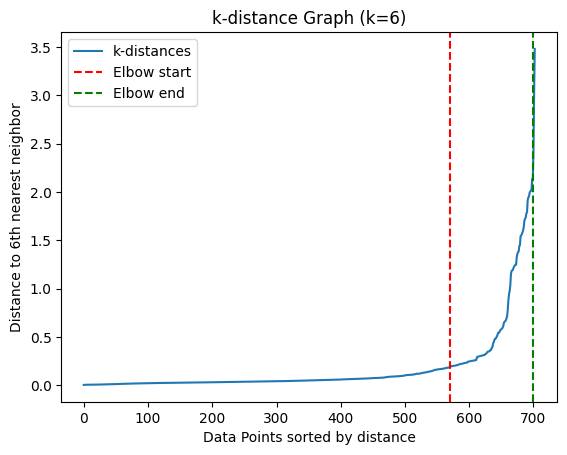

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import statistics



# k 값을 설정 (예: 4)
k = 6

# NearestNeighbors 모델을 사용하여 이웃 계산
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(path_vectors)

# 각 데이터 포인트의 k번째 이웃까지의 거리 계산
distances, indices = neigh.kneighbors(path_vectors)

# k번째 이웃까지의 거리만 추출 (k번째 이웃의 거리를 사용)
k_distances = distances[:, -1]

# k-거리를 오름차순으로 정렬
k_distances = np.sort(k_distances)

# k-거리의 차이 계산 (기울기)
gradients = np.diff(k_distances)

# 기울기의 변화량 계산
gradients_diff = np.diff(gradients)

# 급격한 변화가 발생하는 인덱스 찾기 (최초의 큰 변화 찾기)
threshold = np.percentile(gradients_diff, 95)  # 기울기 변화 중 상위 5%를 임계값으로 설정
print('threshold',threshold)
elbow_start = np.argmax(gradients_diff > threshold)  # 첫 번째 급격한 변화 지점
elbow_end = len(gradients_diff) - np.argmax(np.flip(gradients_diff) > threshold) - 1  # 마지막 급격한 변화 지점

# y-좌표 값 출력 (k-거리)
y_values = k_distances[elbow_start:elbow_end + 2]
print(y_values)
eps_opt=statistics.median(y_values) # 중앙값으로 결정
print(f"eps_opt:{eps_opt}")


# k-거리 그래프 시각화
plt.plot(k_distances, label='k-distances')
plt.axvline(x=elbow_start, color='r', linestyle='--', label='Elbow start')
plt.axvline(x=elbow_end, color='g', linestyle='--', label='Elbow end')
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title(f"k-distance Graph (k={k})")
plt.legend()
plt.show()


### min_samples, eps변경에 따른 silhouette_score 비교

silhouette_score가 1에 가까울수록 적합도가 높다고 평가

In [5]:
from sklearn.metrics import silhouette_score

def evaluate_dbscan(data, eps_values, min_samples_values):
    best_score = -1
    best_eps = None
    best_min_samples = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            if len(set(labels)) > 1:  # 최소 두 개 이상의 클러스터가 필요
                score = silhouette_score(data, labels, metric='euclidean')
                print(f'eps={eps}, min_samples={min_samples}, silhouette_score={score}')
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    return best_eps, best_min_samples

# 예시 사용
eps_values = np.arange(0.3, 0.5, 0.1)
min_samples_values = range(20, 50, 5)
data = np.concatenate(lat_lng_values)  # 모든 데이터 포인트를 하나로 결합
best_eps, best_min_samples = evaluate_dbscan(data, eps_values, min_samples_values)

print(f'Best eps: {best_eps}, Best min_samples: {best_min_samples}')


KeyboardInterrupt: 